# Backtesting Framework Example Usage

This notebook demonstrates how to use the backtesting framework with a RandomStrategy. 

## Overview
- **Data**: Bitcoin (BTCUSDT) 1-minute OHLCV data
- **Strategy**: RandomStrategy - Makes random buy/sell decisions
- **Initial Capital**: $100,000
- **Trading Fee**: 0.1% per trade

## Components
1. **DataLoader**: Loads and manages historical price data
2. **RandomStrategy**: A simple strategy that makes random trades
3. **Portfolio**: Tracks cash, positions, and performance
4. **Broker**: Executes trades with fees and slippage
5. **BacktesterEngine**: Orchestrates the entire backtest

Run the cells below in order to see the framework in action!

In [1]:
# Add parent directory to path to import backtester modules
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Data loaded successfully!
Data shape: (217441, 7)
Date range: 2022-12-31 22:00:00 to 2023-05-31 22:00:00

First few rows:
             timestamp     open     high      low    close   volume  \
0  2022-12-31 22:00:00  16544.0  16544.3  16540.6  16541.0  257.084   
1  2022-12-31 22:01:00  16540.9  16541.9  16540.9  16541.5   59.582   
2  2022-12-31 22:02:00  16541.5  16541.5  16540.5  16541.4   71.693   
3  2022-12-31 22:03:00  16541.5  16541.5  16541.0  16541.1   28.035   
4  2022-12-31 22:04:00  16541.1  16542.5  16540.3  16542.4   95.339   

   quote_asset_volume  
0        4.252827e+06  
1        9.855661e+05  
2        1.185868e+06  
3        4.637381e+05  
4        1.577066e+06  

Price statistics:
Min price: $16,461.80
Max price: $31,059.00
Final price: $27,090.60


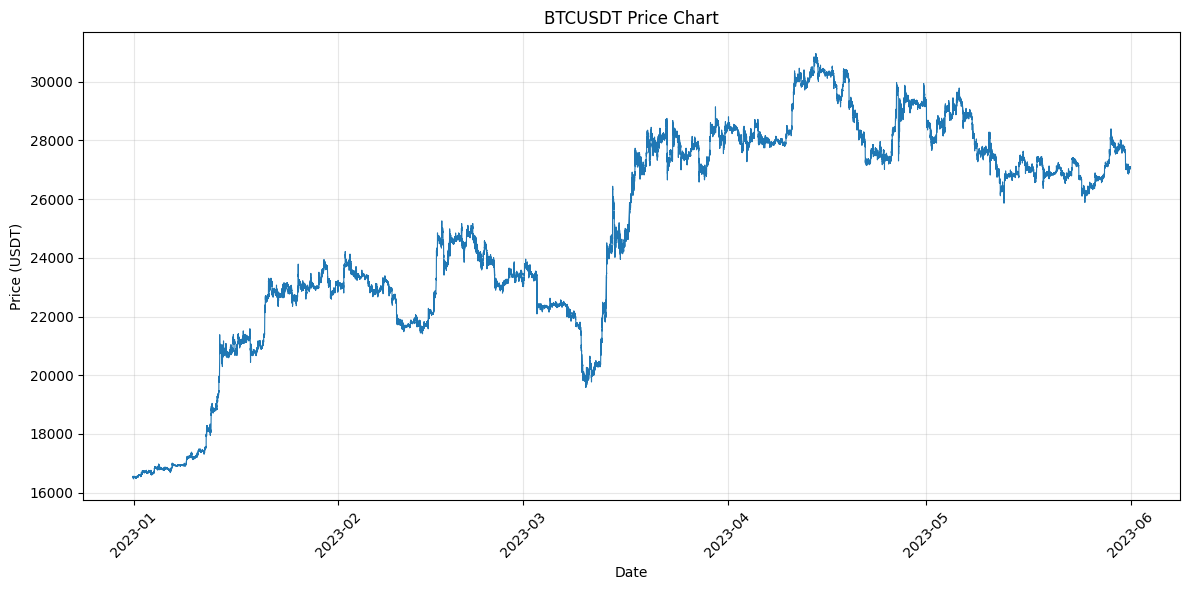

In [2]:
# Load data using DataLoader
from backtester.data_loader import DataLoader

# Initialize DataLoader (adjust path to data directory)
loader = DataLoader(base_path="../data")

# Load Bitcoin data
btc_df = loader.load_symbol("BTCUSDT", file_type="csv")
print("Data loaded successfully!")
print(f"Data shape: {btc_df.shape}")
print(f"Date range: {btc_df['timestamp'].min()} to {btc_df['timestamp'].max()}")
print("\nFirst few rows:")
print(btc_df.head())

# Convert timestamp to datetime for easier handling
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Show basic statistics
print(f"\nPrice statistics:")
print(f"Min price: ${btc_df['low'].min():,.2f}")
print(f"Max price: ${btc_df['high'].max():,.2f}")
print(f"Final price: ${btc_df['close'].iloc[-1]:,.2f}")

# Plot price chart
plt.figure(figsize=(12, 6))
plt.plot(btc_df['timestamp'], btc_df['close'], linewidth=0.8)
plt.title('BTCUSDT Price Chart')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Set up and run backtest with RandomStrategy
from backtester.engine import BacktesterEngine
from backtester.broker import Broker
from backtester.portfolio import Portfolio
from backtester.Strategies.random_strategy import RandomStrategy

# Initialize portfolio and broker
initial_cash = 100_000  # $100,000 starting capital
portfolio = Portfolio(initial_cash=initial_cash)
broker = Broker(portfolio, fee_rate=0.001)  # 0.1% trading fee

# Create RandomStrategy instance
symbols = ["BTCUSDT"]
strategy = RandomStrategy(
    symbol="BTCUSDT", 
    seed=42,  # For reproducible results
    trade_probability=0.02,  # 2% chance to trade on each candle
    max_position_size=0.05   # Max 10% of portfolio per trade (increased from 0.05)
)

# Initialize backtester engine
engine = BacktesterEngine([strategy], symbols, broker, portfolio)

# Load data into engine
print("Loading data into backtest engine...")
for sym in symbols:
    engine.load_data(sym, loader.get_data(sym))

print(f"Loaded {len(btc_df)} candles for backtesting")

# Initialize strategies
print("Initializing strategies...")
engine.initialize()

print("Starting backtest...")
print("This may take a moment for large datasets...")

# Run the backtest
engine.run_backtest()

print("Backtest completed!")

Loading data into backtest engine...
Loaded 217441 candles for backtesting
Initializing strategies...
RandomStrategy initialized for BTCUSDT
Starting backtest...
This may take a moment for large datasets...
BUY 0.002217 BTCUSDT at 16503.30
Fill: BOUGHT 0.002217 BTCUSDT at 16503.30, fee: 0.0366
SELL 0.000924 BTCUSDT at 16532.60
Fill: SOLD 0.000924 BTCUSDT at 16532.60, fee: 0.0153
SELL 0.002610 BTCUSDT at 16544.10
Fill: SOLD 0.002610 BTCUSDT at 16544.10, fee: 0.0432
SELL 0.002604 BTCUSDT at 16517.20
Fill: SOLD 0.002604 BTCUSDT at 16517.20, fee: 0.0430
SELL 0.002073 BTCUSDT at 16516.00
Fill: SOLD 0.002073 BTCUSDT at 16516.00, fee: 0.0342
BUY 0.002676 BTCUSDT at 16543.40
Fill: BOUGHT 0.002676 BTCUSDT at 16543.40, fee: 0.0443
SELL 0.001875 BTCUSDT at 16539.50
Fill: SOLD 0.001875 BTCUSDT at 16539.50, fee: 0.0310
SELL 0.002308 BTCUSDT at 16515.00
Fill: SOLD 0.002308 BTCUSDT at 16515.00, fee: 0.0381
BUY 0.002246 BTCUSDT at 16516.20
Fill: BOUGHT 0.002246 BTCUSDT at 16516.20, fee: 0.0371
SELL 0.

In [4]:
# Analyze backtest results
print("=== BACKTEST RESULTS ===")

# Portfolio performance
final_equity = portfolio.equity({symbols[0]: btc_df['close'].iloc[-1]})
total_return = (final_equity - initial_cash) / initial_cash * 100
print(f"Initial Capital: ${initial_cash:,.2f}")
print(f"Final Equity: ${final_equity:,.2f}")
print(f"Total Return: {total_return:.2f}%")

# Position summary
print(f"\n=== FINAL POSITIONS ===")
for symbol, position in portfolio.positions.items():
    print(f"{symbol}: {position.size:.6f} (Avg Price: ${position.avg_price:.2f}, Realized PnL: ${position.realized_pnl:.2f})")

print(f"Cash Remaining: ${portfolio.cash:,.2f}")

# Trade statistics
fills = broker.get_fills()
print(f"\n=== TRADE STATISTICS ===")
print(f"Total Trades: {len(fills)}")
if fills:
    buy_trades = [f for f in fills if f.is_buy]
    sell_trades = [f for f in fills if not f.is_buy]
    print(f"Buy Trades: {len(buy_trades)}")
    print(f"Sell Trades: {len(sell_trades)}")
    
    total_fees = sum(f.fee for f in fills)
    print(f"Total Fees Paid: ${total_fees:.2f}")
    
    avg_trade_size = np.mean([f.price * f.size for f in fills])
    print(f"Average Trade Size: ${avg_trade_size:.2f}")

# Buy and Hold comparison
buy_hold_return = (btc_df['close'].iloc[-1] / btc_df['close'].iloc[0] - 1) * 100
print(f"\n=== BENCHMARK COMPARISON ===")
print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
print(f"Strategy Return: {total_return:.2f}%")
print(f"Excess Return: {total_return - buy_hold_return:.2f}%")

=== BACKTEST RESULTS ===
Initial Capital: $100,000.00
Final Equity: $99,873.00
Total Return: -0.13%

=== FINAL POSITIONS ===
BTCUSDT: -0.006618 (Avg Price: $27067.12, Realized PnL: $-0.03)
Cash Remaining: $100,052.30

=== TRADE STATISTICS ===
Total Trades: 4296
Buy Trades: 2172
Sell Trades: 2124
Total Fees Paid: $127.92
Average Trade Size: $29.78

=== BENCHMARK COMPARISON ===
Buy & Hold Return: 63.78%
Strategy Return: -0.13%
Excess Return: -63.91%


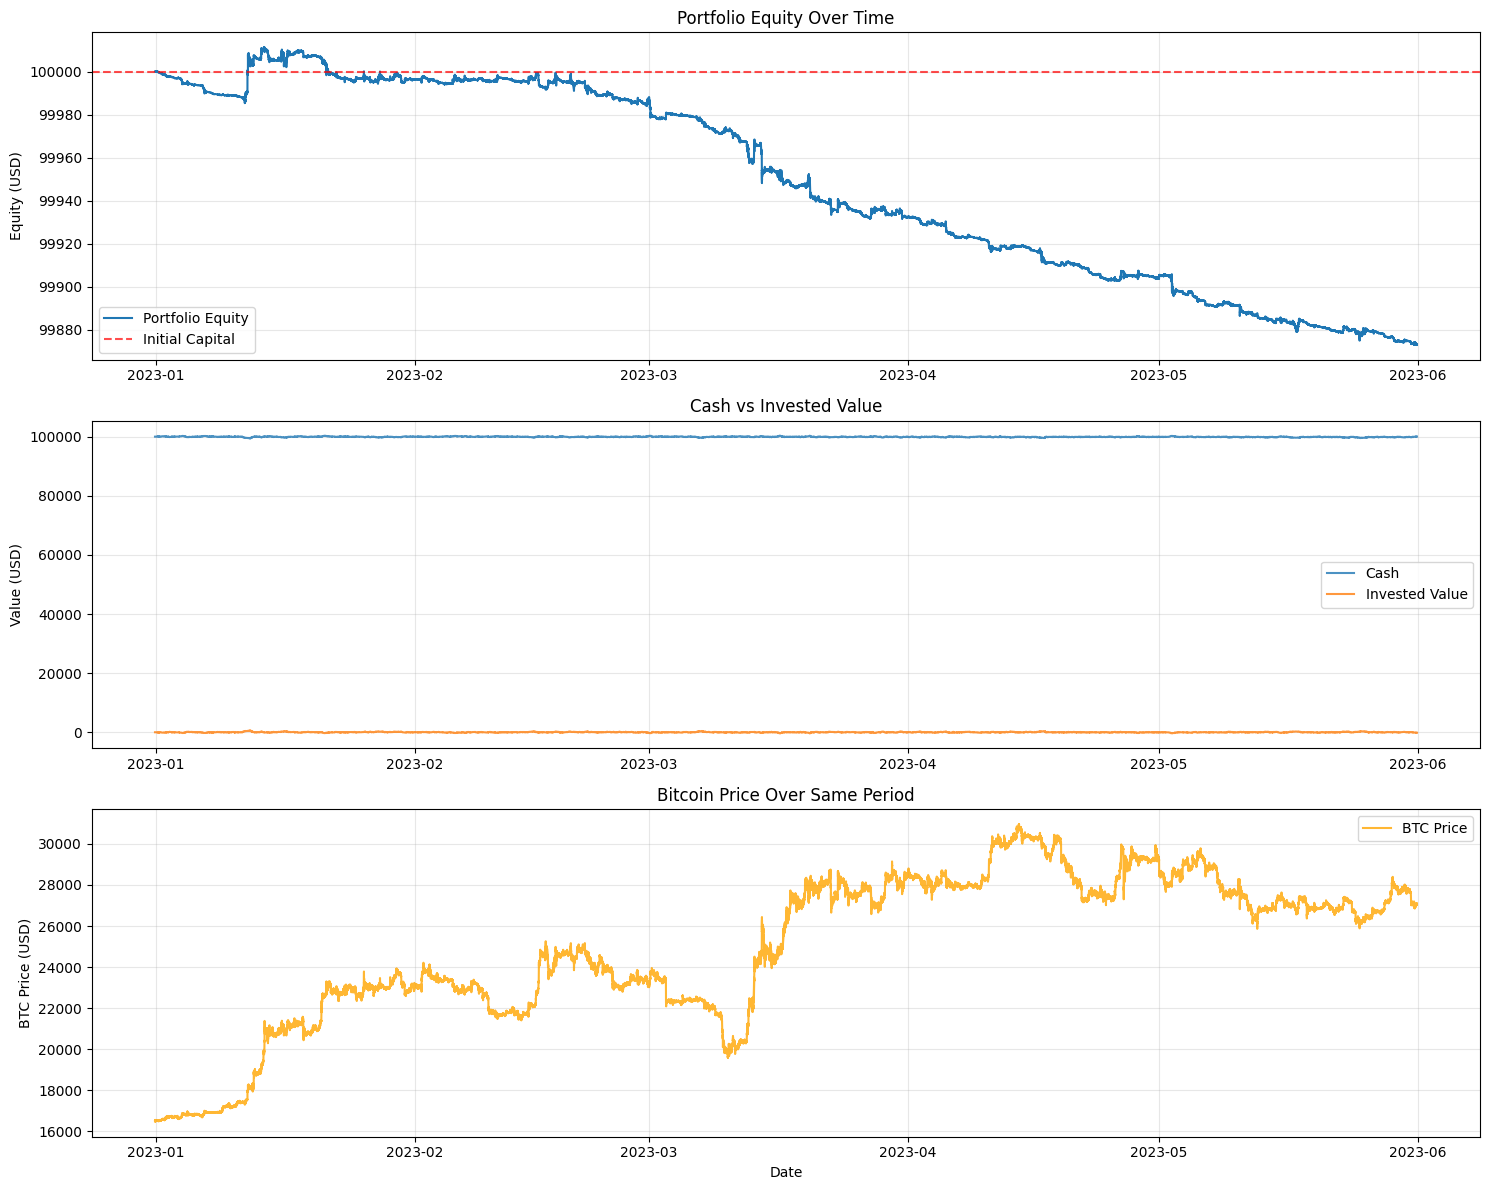

=== PERFORMANCE METRICS ===
Sharpe Ratio (annualized): -6.08
Volatility (annualized): 0.05%
Max Drawdown: -0.14%


In [5]:
# Portfolio performance visualization
if portfolio.history:
    # Extract portfolio history
    timestamps = [snap.timestamp for snap in portfolio.history]
    equity_values = [snap.equity for snap in portfolio.history]
    cash_values = [snap.cash for snap in portfolio.history]
    
    # Convert timestamps to datetime if needed
    timestamps = pd.to_datetime(timestamps)
    
    # Create performance plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Portfolio equity over time
    ax1.plot(timestamps, equity_values, label='Portfolio Equity', linewidth=1.5)
    ax1.axhline(y=initial_cash, color='r', linestyle='--', alpha=0.7, label='Initial Capital')
    ax1.set_title('Portfolio Equity Over Time')
    ax1.set_ylabel('Equity (USD)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cash vs invested value
    invested_values = [eq - cash for eq, cash in zip(equity_values, cash_values)]
    ax2.plot(timestamps, cash_values, label='Cash', alpha=0.8)
    ax2.plot(timestamps, invested_values, label='Invested Value', alpha=0.8)
    ax2.set_title('Cash vs Invested Value')
    ax2.set_ylabel('Value (USD)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Bitcoin price for comparison
    ax3.plot(btc_df['timestamp'], btc_df['close'], label='BTC Price', alpha=0.8, color='orange')
    ax3.set_title('Bitcoin Price Over Same Period')
    ax3.set_ylabel('BTC Price (USD)')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate rolling returns
    equity_series = pd.Series(equity_values, index=timestamps)
    returns = equity_series.pct_change().dropna()
    
    # Performance metrics
    print("=== PERFORMANCE METRICS ===")
    if len(returns) > 0:
        sharpe_ratio = returns.mean() / returns.std() * np.sqrt(365 * 24 * 60)  # Assuming 1-minute data
        print(f"Sharpe Ratio (annualized): {sharpe_ratio:.2f}")
        print(f"Volatility (annualized): {returns.std() * np.sqrt(365 * 24 * 60) * 100:.2f}%")
        print(f"Max Drawdown: {((equity_series / equity_series.cummax()) - 1).min() * 100:.2f}%")
else:
    print("No portfolio history available for visualization.")

=== TRADE ANALYSIS ===
Total trades executed: 4296
Average trade value: $29.78
Largest trade: $49.99
Smallest trade: $10.01


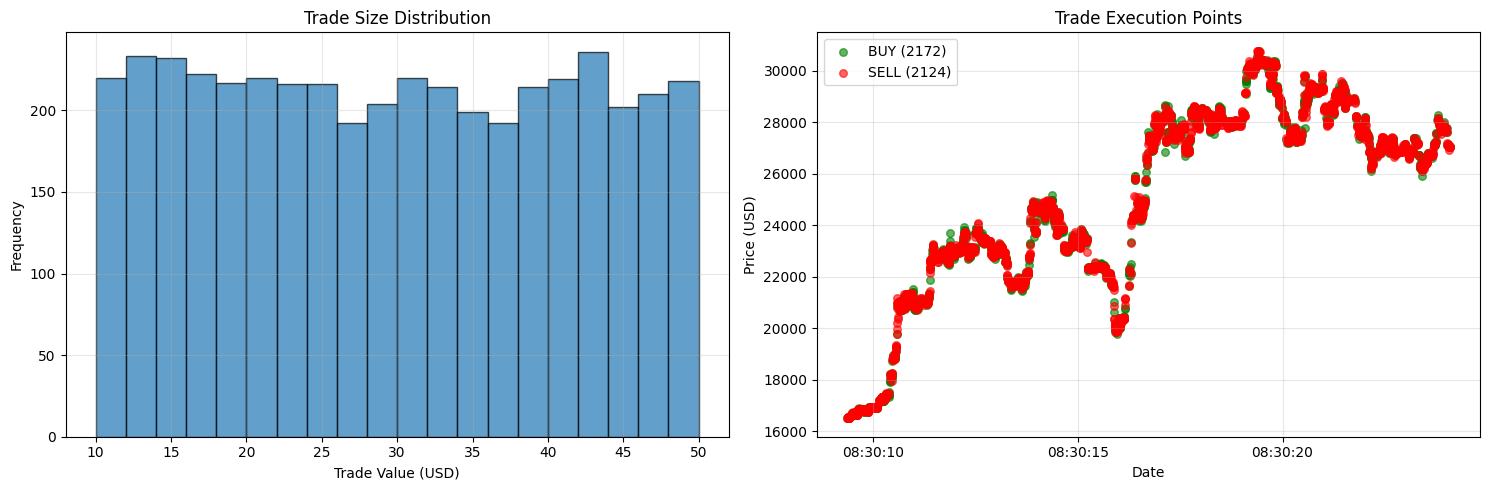


=== RECENT TRADES (Last 10) ===
                 timestamp side   price     size     value      fee
2025-10-15 08:30:24.053570 SELL 27147.0 0.001658 45.000928 0.045001
2025-10-15 08:30:24.066644 SELL 26908.0 0.000514 13.843253 0.013843
2025-10-15 08:30:24.072252 SELL 27049.7 0.001507 40.760076 0.040760
2025-10-15 08:30:24.072412 SELL 27040.5 0.001240 33.535966 0.033536
2025-10-15 08:30:24.078091 SELL 27023.4 0.001668 45.076829 0.045077
2025-10-15 08:30:24.078730  BUY 27029.4 0.001096 29.612677 0.029613
2025-10-15 08:30:24.079013  BUY 27028.2 0.001425 38.504408 0.038504
2025-10-15 08:30:24.082451 SELL 27040.3 0.000769 20.791179 0.020791
2025-10-15 08:30:24.086704 SELL 27037.7 0.000510 13.776311 0.013776
2025-10-15 08:30:24.087078 SELL 27056.8 0.001587 42.946794 0.042947


In [6]:
# Trade analysis and visualization
if fills:
    # Create trade analysis DataFrame
    trades_data = []
    for fill in fills:
        trades_data.append({
            'timestamp': fill.timestamp,
            'symbol': fill.symbol,
            'side': 'BUY' if fill.is_buy else 'SELL',
            'price': fill.price,
            'size': fill.size,
            'value': fill.price * fill.size,
            'fee': fill.fee
        })
    
    trades_df = pd.DataFrame(trades_data)
    trades_df['timestamp'] = pd.to_datetime(trades_df['timestamp'])
    
    print("=== TRADE ANALYSIS ===")
    print(f"Total trades executed: {len(trades_df)}")
    print(f"Average trade value: ${trades_df['value'].mean():,.2f}")
    print(f"Largest trade: ${trades_df['value'].max():,.2f}")
    print(f"Smallest trade: ${trades_df['value'].min():,.2f}")
    
    # Plot trade distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Trade sizes histogram - handle case where all values are effectively the same
    unique_values = trades_df['value'].nunique()
    value_range = trades_df['value'].max() - trades_df['value'].min()
    
    if unique_values > 1 and value_range > 0.01:
        # Normal case: values have meaningful variation
        ax1.hist(trades_df['value'], bins=min(20, unique_values), alpha=0.7, edgecolor='black')
    else:
        # Special case: all values are the same or very close
        unique_value = trades_df['value'].iloc[0]
        ax1.bar([unique_value], [len(trades_df)], width=max(unique_value*0.01, 1), alpha=0.7, edgecolor='black')
        ax1.set_xlim(unique_value*0.95, unique_value*1.05)
        
    ax1.set_title('Trade Size Distribution')
    ax1.set_xlabel('Trade Value (USD)')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Trade timing
    buy_trades = trades_df[trades_df['side'] == 'BUY']
    sell_trades = trades_df[trades_df['side'] == 'SELL']
    
    ax2.scatter(buy_trades['timestamp'], buy_trades['price'], 
               color='green', alpha=0.6, s=30, label=f'BUY ({len(buy_trades)})')
    ax2.scatter(sell_trades['timestamp'], sell_trades['price'], 
               color='red', alpha=0.6, s=30, label=f'SELL ({len(sell_trades)})')
    ax2.set_title('Trade Execution Points')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price (USD)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show recent trades
    print("\n=== RECENT TRADES (Last 10) ===")
    recent_trades = trades_df.tail(10)[['timestamp', 'side', 'price', 'size', 'value', 'fee']]
    print(recent_trades.to_string(index=False))
else:
    print("No trades were executed during the backtest.")

In [7]:
# Experiment with different strategy parameters
print("=== PARAMETER SENSITIVITY ANALYSIS ===")
print("Testing different RandomStrategy parameters...\n")

# Test different parameter combinations
test_configs = [
    {"trade_probability": 0.01, "max_position_size": 0.02, "name": "Conservative"},
    {"trade_probability": 0.05, "max_position_size": 0.10, "name": "Aggressive"},
    {"trade_probability": 0.02, "max_position_size": 0.05, "name": "Balanced"}
]

results = []

for config in test_configs:
    print(f"Testing {config['name']} configuration:")
    print(f"  Trade Probability: {config['trade_probability']}")
    print(f"  Max Position Size: {config['max_position_size']}")
    
    # Create new instances for each test
    test_portfolio = Portfolio(initial_cash=100_000)
    test_broker = Broker(test_portfolio, fee_rate=0.001)
    test_strategy = RandomStrategy(
        symbol="BTCUSDT", 
        seed=42,  # Same seed for fair comparison
        trade_probability=config['trade_probability'],
        max_position_size=config['max_position_size']
    )
    
    test_engine = BacktesterEngine([test_strategy], ["BTCUSDT"], test_broker, test_portfolio)
    
    # Load data (use first 10,000 candles for speed)
    test_data = btc_df.head(10000).copy()
    test_engine.load_data("BTCUSDT", test_data)
    test_engine.initialize()
    test_engine.run_backtest()
    
    # Calculate results
    final_eq = test_portfolio.equity({"BTCUSDT": test_data['close'].iloc[-1]})
    total_ret = (final_eq - 100_000) / 100_000 * 100
    num_trades = len(test_broker.get_fills())
    
    results.append({
        'name': config['name'],
        'final_equity': final_eq,
        'return_pct': total_ret,
        'num_trades': num_trades
    })
    
    print(f"  Result: ${final_eq:,.2f} ({total_ret:.2f}%) with {num_trades} trades")
    print()

# Summary comparison
print("=== COMPARISON SUMMARY ===")
for result in results:
    print(f"{result['name']:12s}: {result['return_pct']:6.2f}% return, {result['num_trades']:3d} trades")

best_config = max(results, key=lambda x: x['return_pct'])
print(f"\nBest performer: {best_config['name']} with {best_config['return_pct']:.2f}% return")

print("\nNote: This is a simple random strategy for demonstration purposes.")
print("In practice, you would implement strategies based on technical analysis,")
print("machine learning models, or fundamental analysis.")

=== PARAMETER SENSITIVITY ANALYSIS ===
Testing different RandomStrategy parameters...

Testing Conservative configuration:
  Trade Probability: 0.01
  Max Position Size: 0.02
RandomStrategy initialized for BTCUSDT
BUY 0.001009 BTCUSDT at 16503.30
Fill: BOUGHT 0.001009 BTCUSDT at 16503.30, fee: 0.0166
SELL 0.000972 BTCUSDT at 16517.80
Fill: SOLD 0.000972 BTCUSDT at 16517.80, fee: 0.0161
SELL 0.001031 BTCUSDT at 16522.90
Fill: SOLD 0.001031 BTCUSDT at 16522.90, fee: 0.0170
BUY 0.001016 BTCUSDT at 16508.80
Fill: BOUGHT 0.001016 BTCUSDT at 16508.80, fee: 0.0168
SELL 0.001127 BTCUSDT at 16535.20
Fill: SOLD 0.001127 BTCUSDT at 16535.20, fee: 0.0186
BUY 0.000901 BTCUSDT at 16534.40
Fill: BOUGHT 0.000901 BTCUSDT at 16534.40, fee: 0.0149
SELL 0.000624 BTCUSDT at 16532.00
Fill: SOLD 0.000624 BTCUSDT at 16532.00, fee: 0.0103
BUY 0.000980 BTCUSDT at 16529.10
Fill: BOUGHT 0.000980 BTCUSDT at 16529.10, fee: 0.0162
SELL 0.001205 BTCUSDT at 16543.10
Fill: SOLD 0.001205 BTCUSDT at 16543.10, fee: 0.0199